In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mydata-new/mydata/vali/S1167L/S1167L08.jpg
/kaggle/input/mydata-new/mydata/vali/S1167L/S1167L01.jpg
/kaggle/input/mydata-new/mydata/vali/S1043L/S1043L06.jpg
/kaggle/input/mydata-new/mydata/vali/S1043L/S1043L09.jpg
/kaggle/input/mydata-new/mydata/vali/S1212L/S1212L01.jpg
/kaggle/input/mydata-new/mydata/vali/S1212L/S1212L05.jpg
/kaggle/input/mydata-new/mydata/vali/S1168R/S1168R06.jpg
/kaggle/input/mydata-new/mydata/vali/S1168R/S1168R05.jpg
/...
/kaggle/input/roi-output2/ROI_output/train/S1097R/S1097R07.jpg
/kaggle/input/roi-output2/ROI_output/train/S1097R/S1097R01.jpg
/kaggle/input/roi-output2/ROI_output/train/S1097R/S1097R03.jpg
/kaggle/input/roi-output2/ROI_output/train/S1097R/S1097R05.jpg
/kaggle/input/roi-output2/ROI_output/train/S1097R/S1097R02.jpg
/kaggle/input/roi-output2/ROI_output/train/S1012R/S1012R06.jpg
/kaggle/input/roi-output2/ROI_output/train/S1012R/S1012R05.jpg
/kaggle/input/roi-output2/ROI_output/train/S1012R/S1012R01.jpg
/kaggle/input/roi-output2/ROI_outpu

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from random import randint
import time
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np
import imp
from IPython.display import clear_output
import pandas as pd
bs = 64

from torch.utils.data import Dataset, DataLoader
import torchmetrics
from torchmetrics import Dice, JaccardIndex
import albumentations as A
from albumentations.pytorch import ToTensorV2 # np.array -> torch.tensor
import os
from tqdm import tqdm
from glob import glob

import random
from PIL import Image
import PIL.ImageOps    

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils
from torch.autograd import Variable

2024-06-12 11:42:24.554357: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 11:42:24.554461: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 11:42:24.682313: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_25/2860380791.py:15: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [3]:
# Creating some helper functions
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [4]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look untill a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [5]:
# Load the training dataset
folder_dataset_train = datasets.ImageFolder(root="/kaggle/input/roi-output2/ROI_output/train")
folder_dataset_test = datasets.ImageFolder(root="/kaggle/input/roi-output2/ROI_output/test")

In [6]:
# Resize the images and transform to tensors
train_transformation = transforms.Compose([
    transforms.Resize((200, 200)),  # Thay đổi kích thước ảnh về 200x200
    transforms.RandomHorizontalFlip(p=0.5),  # Lật ngang ảnh với xác suất 50%
    transforms.RandomVerticalFlip(p=0.5),  # Lật dọc ảnh với xác suất 50%
    transforms.RandomRotation(degrees=30),  # Xoay ngẫu nhiên ảnh trong khoảng 30 độ
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Điều chỉnh độ sáng, tương phản, bão hòa màu và màu sắc ngẫu nhiên
    transforms.ToTensor(),  # Chuyển đổi ảnh sang tensor
])

test_transformation = transforms.Compose([
    transforms.Resize((200, 200)),  # Thay đổi kích thước ảnh về 200x200
    transforms.ToTensor(),  # Chuyển đổi ảnh sang tensor
])
# Initialize the network
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_train,
                                        transform=train_transformation)
siamese_dataset_test = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=test_transformation)

In [7]:
# In ra kích thước của 1 ảnh sau khi áp dụng biến đổi
sample_img = siamese_dataset[0][0]
print("Kích thước của 1 ảnh sau khi áp dụng biến đổi:", sample_img.shape)

# In ra kích thước của 1 phần tử trong siamese_dataset
sample_element = siamese_dataset[0]
print("Kích thước của 1 phần tử trong siamese_dataset:", len(siamese_dataset))


Kích thước của 1 ảnh sau khi áp dụng biến đổi: torch.Size([1, 200, 200])
Kích thước của 1 phần tử trong siamese_dataset: 2600


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


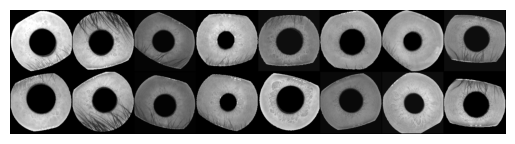

[0. 0. 0. 0. 1. 1. 1. 0.]


In [8]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 0, it means that it is not the same person, label is 1, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [9]:
siamese_dataloader = DataLoader(siamese_dataset, batch_size=bs , shuffle = True)


In [10]:
distance = nn.PairwiseDistance(p=1)
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidian distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [11]:
!pip install einops
clear_output()

In [12]:
import torch
import numpy as np
from torch import nn
from einops.layers.torch import Rearrange


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class MixerBlock(nn.Module):
    def __init__(self, dim, num_patch, token_dim, channel_dim, dropout = 0.2):
        super().__init__()
        
        self.token_mix = nn.Sequential(
            nn.LayerNorm(dim),
            Rearrange('b n d -> b d n'),
            FeedForward(num_patch, token_dim, dropout),
            Rearrange('b d n -> b n d')
        )
        
        self.channel_mix = nn.Sequential(
            nn.LayerNorm(dim),
            FeedForward(dim, channel_dim, dropout),
        )
    def forward(self, x):
        x = x + self.token_mix(x)
        x = x + self.channel_mix(x)
        
        
        return x


class HybridModel(nn.Module):
    def __init__(self, in_channels, dim, inner_dim, num_classes, depth, token_dim, channel_dim):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels,inner_dim,kernel_size=3,padding=1),  # Thay đổi in_channels thành 3
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(inner_dim),
            nn.GELU(),
            nn.Conv2d(inner_dim,dim,kernel_size=3,padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(dim),
            nn.GELU(),
            Rearrange('b c h w -> b (h w) c'),
        )
        
        self.mixer_blocks = nn.ModuleList([])
        for _ in range(depth):
            self.mixer_blocks.append(MixerBlock(dim, 256, token_dim, channel_dim))

        self.layer_norm = nn.LayerNorm(dim)
        self.linear = nn.Linear(dim, num_classes)

    def forward(self, x):
        x = self.conv(x)
        for mixer_block in self.mixer_blocks:
            x = mixer_block(x)
        x = self.layer_norm(x)
        x = x.mean(dim=1)
        x = self.linear(x)
        return x

In [13]:
model1 = HybridModel(in_channels=1, num_classes=2, dim=256, inner_dim=128, depth=1, token_dim=512, channel_dim=512)
checking = torch.rand([1,1,64,64])
model1(checking).shape

torch.Size([1, 2])

In [14]:
class convMixerLayer(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size) -> None:
        super().__init__()
        self.depthwise = nn.Conv2d(
            in_channels=in_channel, 
            out_channels=out_channel, 
            groups=in_channel, 
            kernel_size=kernel_size,
            stride=1,
            padding="same"
        )
        self.pointwise = nn.Conv2d(in_channel, out_channel, 1, 1)
        self.activation = nn.GELU()
        self.batchnorm1 = nn.BatchNorm2d(out_channel)
        self.batchnorm2 = nn.BatchNorm2d(out_channel)
        #self.trans = MHSA(n_dims = out_channel, width=64, height=64, heads=4)
    
    def forward(self, x):
        ori = x
        #x = self.trans(x)
        x = self.depthwise(x)
        x = self.activation(x)
        x = self.batchnorm1(x) + ori
        x = self.pointwise(x)
        x = self.activation(x)
        x = self.batchnorm2(x)
        return x

class SiameseNetwork(nn.Module):
    def __init__(self, patch_size = 3, kernel_size = 3, h = 64, depth = 10, num_classes = 2) -> None:
        super().__init__()
        self.depth = depth
        self.patch_embed = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=h, kernel_size=patch_size, stride=patch_size),  # Thay đổi in_channels thành 3
            nn.GELU(),
            nn.BatchNorm2d(h)
        )
        convmix = [convMixerLayer(h, h, kernel_size) for i in range(depth)]
        self.convmix = nn.Sequential(*convmix)
        self.gbpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(h, num_classes)
        #self.trans = MHSA(n_dims = h, width=21, height=21, heads=4)
    
    def forward(self, x):
        x = self.patch_embed(x)
        x = self.convmix(x)
        #---Transformer---#
        #x = self.trans(x)
        #-----------------#
        x = self.gbpool(x)
        x = x.view(x.shape[0], -1)
        x = self.linear(x)
        return x

In [15]:
model = SiameseNetwork()

In [16]:
# Tính toán mean và std trên train_data
train_data = torch.stack([siamese_dataset[i][0] for i in range(len(siamese_dataset))])
mean = train_data.mean()
std = train_data.std()

# Chuyển đổi kết quả sang kiểu tensor và đưa lên GPU (nếu có)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mean = mean.to(device)
std = std.to(device)

# To CUDA (nếu bạn muốn đưa model lên GPU)
model = model.to(device)

In [17]:
def Train(model, criterion, optimizer, siamese_dataloader, device, mean, std):
    model.train()
    running_loss=0
    num_batches=0
    for i, data in enumerate(siamese_dataloader, 0):
        img1, img2 , label = data
        img1 = img1.to(device)
        img2 = img2.to(device)
        img1 = (img1 - mean)/std
        img2 = (img2 - mean)/std
        label = label.to(device)
        optimizer.zero_grad()
        output1 = model(img1)
        output2 = model(img2)
        distance_score = distance(output1, output2)
        distance_score = distance_score.unsqueeze(dim=1)
        ##---------Using constrastive loss------#
        loss = criterion(output1, output2, label)
        #---------Using casual loss------------#
        #loss = criterion(distance_score, label)
        loss.backward()
        optimizer.step()
        loss_detech = loss.detach().item()
        running_loss += loss_detech
        num_batches += 1
        #---Compute average loss per batchsize----#
        loss_bs = running_loss/num_batches
    return loss_bs

In [18]:
siamese_dataloader_check = DataLoader(siamese_dataset, batch_size=1, shuffle=True)
siamese_dataloader_test = DataLoader(siamese_dataset_test, batch_size=1, shuffle=False)
def On_Testset(model, siamese_dataloader_test, mean, std, device):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(siamese_dataloader_test):
            img1, img2, label = data
            img1 = img1.to(device)
            img2 = img2.to(device)
            img1 = (img1 - mean)/std
            img2 = (img2 - mean)/std
            label = label.to(device)
            output1 = model(img1)
            output2 = model(img2)
            #output1, output2 = model(img1, img2)
            euclidean_distance = distance(output1, output2)
            if (euclidean_distance < 0.5):
              predictions = 0
            else:
              predictions = 1
            #predictions = torch.lt(euclidean_distance, 0.5).tolist()
            total += label.size(0)
            correct += sum(np.array(predictions) == label.tolist())
        accuracy = (correct / total)
    return accuracy.item()

In [19]:
criterion = ContrastiveLoss()
# criterion = nn.MSELoss()
# criterion = nn.BCEWithLogitsLoss()
lr = 0.001
from torch.optim import Adam
import time

# Define the loss function and optimizer
full_loss = []
start = time.time()
the_best_acc = 0
best_epoch = 0
acc_test = []

# train the model
for epoch in range(1, 1000):
    optimizer = Adam(model.parameters(), lr=lr)
    loss_bs = Train(model, criterion, optimizer, siamese_dataloader, device, mean, std)
    acc = On_Testset(model, siamese_dataloader_test, mean, std, device)

    #----Stored loss, accuracy per epoch-----#
    acc_test.append(acc)
    elapsed = (time.time() - start) / 60
    full_loss.append(loss_bs)
    print('epoch=', epoch, '\t time={:.5f} min'.format(elapsed), '\t loss={:.5f}'.format(loss_bs),
          '\t Accuracy on Test set = {:.5f}'.format(acc))
    #---------Save the best model------------#
    if acc > the_best_acc:
        the_best_acc = acc
        best_epoch = epoch
        print("==> This is the best model with Accuracy on test set is {:.5f}".format(acc))
        # save if needed
        data_path = '/kaggle/working/'
        torch.save(model, data_path + 'best_model.pt')
    torch.cuda.empty_cache()

# Print the final statement with the best accuracy and corresponding epoch
print(f"Training completed. Accuracy on test best = {the_best_acc:.5f} in epoch {best_epoch}")


epoch= 1 	 time=0.56552 min 	 loss=1.05714 	 Accuracy on Test set = 0.85341
==> This is the best model with Accuracy on test set is 0.85341
epoch= 2 	 time=1.08468 min 	 loss=0.85075 	 Accuracy on Test set = 0.85051
epoch= 3 	 time=1.60974 min 	 loss=0.78980 	 Accuracy on Test set = 0.85051
epoch= 4 	 time=2.11578 min 	 loss=0.72366 	 Accuracy on Test set = 0.87663
...
epoch= 871 	 time=446.74657 min 	 loss=0.24153 	 Accuracy on Test set = 0.93469
epoch= 872 	 time=447.25939 min 	 loss=0.23816 	 Accuracy on Test set = 0.92017
epoch= 873 	 time=447.78374 min 	 loss=0.23588 	 Accuracy on Test set = 0.94485
epoch= 874 	 time=448.29103 min 	 loss=0.22445 	 Accuracy on Test set = 0.96807
==> This is the best model with Accuracy on test set is 0.96807
...
epoch= 998 	 time=512.82846 min 	 loss=0.22620 	 Accuracy on Test set = 0.92743
epoch= 999 	 time=513.35179 min 	 loss=0.21335 	 Accuracy on Test set = 0.94340
Training completed. Accuracy on test best = 0.96807 in epoch 874
